In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape

M, D, C = X_train.shape[0], X_train.shape[1], y_train.max() + 1
# M, D, C

X_train, X_val, X_test = l.prepro(X_train, X_val, X_test)
# X_train.shape, X_val.shape, X_test.shape
# if net_type == 'cnn':
img_shape = (1, 28, 28)
img_shape[:]
# *img_shape
# X_train = X_train.reshape(-1, img_shape[:])
X_train = X_train.reshape(-1, *img_shape)
# X_train = X_train.reshape(-1, img_shape[0], img_shape[1], img_shape[2])
X_val = X_val.reshape(-1, *img_shape)
X_test = X_test.reshape(-1, *img_shape)
X_train.shape, X_val.shape, X_test.shape

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class CNN:

    def __init__(self, D, C, H, L, p_dropout):
        self.mode = 'classification'
        self.L = L # number of layers or depth
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model parameters: weights and biases
        # Input layer of Conv
        self.model = []
        self.model.append(dict(
            W1=np.random.randn(H, 1, 3, 3) / np.sqrt(H / 2.),
            b1=np.zeros((H, 1)),
        ))
        
        # Hidden layers of Conv-bn-relu-dropout
        m = []
        for _ in range(self.L):
            m.append(dict(
                W2=np.random.randn(H, H, 3, 3) / np.sqrt(H / 2.),
                b2=np.zeros((H, 1)),
            ))
        self.model.append(m) # self.model[0][]
        
        # Output layer of FC to output
        self.model.append(dict(
            W3=np.random.randn(H*D, C) / np.sqrt(H*D / 2.),
            b3=np.zeros((1, C))
        ))

    def forward(self, X, train):
        # 1st layer - Input layer: X
        X, X_conv_cache = l.conv_forward(X=X, W=self.model[0]['W1'], b=self.model[0]['b1'])
        X_cache = X_conv_cache

        # 2nd layers - Hidden layers: h
        h_cache = []
        for layer in range(self.L):
            h, h_conv_cache = l.conv_forward(X=X, W=self.model[1][layer]['W2'], b=self.model[1][layer]['b2'])
            h, h_nl_cache = l.selu_forward(X=h)
            h += X # residual connection
            if train: 
                # h_do_cache = None # ERROR: referenced before assigned?
                h, h_do_cache = l.alpha_dropout_fwd(h=h, q=self.p_dropout)
                cache = (h_conv_cache, h_nl_cache, h_do_cache)
            else:
                cache = (h_conv_cache, h_nl_cache)
            h_cache.append(cache)
            
        # 3rd layer - Output layer: y
        y = h.reshape([X.shape[0], -1]) # flattening
        y, y_fc_cache = l.fc_forward(X=y, W=self.model[2]['W3'], b=self.model[2]['b3'])
        y_cache = X, y_fc_cache

        cache = (X_cache, h_cache, y_cache)
        
        return y, cache

    def loss_function(self, y, y_train):
        loss = cross_entropy(y, y_train)
        dy = dcross_entropy(y, y_train)
        return loss, dy
    
    def backward(self, dy, cache):
        X_cache, h_cache, y_cache = cache

        # 3rd layer: Ouput layer y
        X, y_fc_cache = y_cache
        dy, dw3, db3 = l.fc_backward(dout=dy, cache=y_fc_cache)
        dy = dy.reshape([-1, *X.shape[1:4]])
        
        # 2nd layers: Hidden layers h
        g = []
        for layer in reversed(range(self.L)):
            # if train: There is no backward in testing/prediction
            h_conv_cache, h_nl_cache, h_do_cache = h_cache[layer]
            dy = l.alpha_dropout_bwd(dout=dy, cache=h_do_cache)
            dh = l.selu_backward(dout=dy, cache=h_nl_cache)
            dh, dw2, db2 = l.conv_backward(dout=dh, cache=h_conv_cache)
            dh += dy
            g.append(dict(
                    W2=dw2,
                    b2=db2
                    ))
            
        # 1st layer: Input layer X
        X_conv_cache = X_cache
        dX, dw1, db1 = l.conv_backward(dout=dh, cache=X_conv_cache)

        # grad for GD
        grad = []
        
        # Input layer to conv layer
        grad.append(dict(
            W1=dw1, 
            b1=db1
        ))
        
        # Hidden layers of conv-bn-nl/relu-dropout/do
        grad.append(g)
        
        # Output later to FC layer
        grad.append(dict(
            W3=dw3, 
            b3=db3
        ))
        
        return dX, grad
    
    def test(self, X):
        y_logit, cache = self.forward(X, train=False)
        y_prob = l.softmax(y_logit)
        if self.mode == 'classification':
            return np.argmax(y_prob, axis=1)
        else: # self.mode == 'regression'
            return np.round(y_logit)
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, X_train, y_train, val_set, alpha, mb_size, n_iter, print_after):
        if val_set:
            X_val, y_val = val_set

        M, R = [], []
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        beta1 = .99
        beta2 = .999
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            y, cache = self.forward(X_mini, train=True)
            loss, dy = self.loss_function(y, y_mini)
            _, grad = self.backward(dy, cache)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)

            for key in grad[0]:
                M[0][key] = l.exp_running_avg(M[0][key], grad[0][key], beta1)
                R[0][key] = l.exp_running_avg(R[0][key], grad[0][key]**2, beta2)

                m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                r_k_hat = R[0][key] / (1. - (beta2**(iter)))

                self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            for layer in range(self.L):
                for key in grad[1][layer]:
                    M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grad[1][layer][key], beta1)
                    R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grad[1][layer][key]**2, beta2)

                    m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))

                    self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            for key in grad[2]:
                M[2][key] = l.exp_running_avg(M[2][key], grad[2][key], beta1)
                R[2][key] = l.exp_running_avg(R[2][key], grad[2][key]**2, beta2)

                m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                r_k_hat = R[2][key] / (1. - (beta2**(iter)))

                self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Epochs
            if iter % print_after == 0:
                if val_set:
                    val_acc = l.accuracy(y_val, self.test(X_val))
                    print('Iter-{} training loss: {:.4f} validation accuracy: {:4f}'.format(iter, loss, val_acc))

Iter-1 training loss: 3.1552 validation accuracy: 0.123800
Iter-2 training loss: 3.0752 validation accuracy: 0.147000
Iter-3 training loss: 3.0747 validation accuracy: 0.168000
Iter-4 training loss: 2.8229 validation accuracy: 0.195400
Iter-5 training loss: 2.9728 validation accuracy: 0.227600
Iter-6 training loss: 2.5076 validation accuracy: 0.257800
Iter-7 training loss: 2.2404 validation accuracy: 0.285400
Iter-8 training loss: 2.0439 validation accuracy: 0.304600
Iter-9 training loss: 2.2893 validation accuracy: 0.323000
Iter-10 training loss: 2.1289 validation accuracy: 0.336200
Iter-11 training loss: 1.9294 validation accuracy: 0.357400
Iter-12 training loss: 2.0771 validation accuracy: 0.375600
Iter-13 training loss: 1.7379 validation accuracy: 0.398600
Iter-14 training loss: 1.9867 validation accuracy: 0.426600
Iter-15 training loss: 2.2030 validation accuracy: 0.450600
Iter-16 training loss: 1.8285 validation accuracy: 0.475600
Iter-17 training loss: 1.9193 validation accuracy

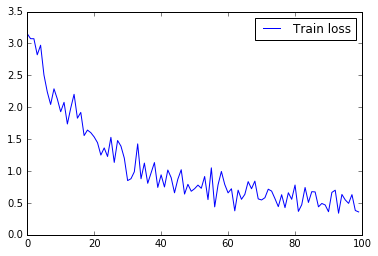

In [6]:
# Hyper-parameters
n_iter = 100 # number of epochs
alpha = 1e-4 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
num_layers = 40 # depth 
print_after = 1 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 10
p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# Build the model/NN and learn it: running session.
nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

# # Kernel dead problem
# y_pred = nn.test(X_test)
# accs = np.mean(y_pred == y_test)
# print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 training loss: 3.1552 validation accuracy: 0.123800
Iter-2 training loss: 3.0752 validation accuracy: 0.147000
Iter-3 training loss: 3.0747 validation accuracy: 0.168000
Iter-4 training loss: 2.8229 validation accuracy: 0.195400
Iter-5 training loss: 2.9728 validation accuracy: 0.227600
Iter-6 training loss: 2.5076 validation accuracy: 0.257800
Iter-7 training loss: 2.2404 validation accuracy: 0.285400
Iter-8 training loss: 2.0439 validation accuracy: 0.304600
Iter-9 training loss: 2.2893 validation accuracy: 0.323000
Iter-10 training loss: 2.1289 validation accuracy: 0.336200
Iter-11 training loss: 1.9294 validation accuracy: 0.357400
Iter-12 training loss: 2.0771 validation accuracy: 0.375600
Iter-13 training loss: 1.7379 validation accuracy: 0.398600
Iter-14 training loss: 1.9867 validation accuracy: 0.426600
Iter-15 training loss: 2.2030 validation accuracy: 0.450600
Iter-16 training loss: 1.8285 validation accuracy: 0.475600
Iter-17 training loss: 1.9193 validation accuracy

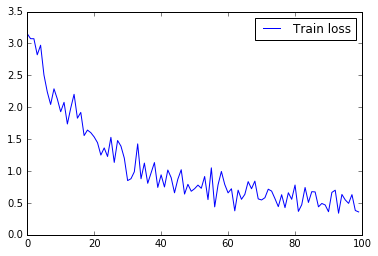

In [6]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 30 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 10
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # Build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 training loss: 3.1552 validation accuracy: 0.123800
Iter-2 training loss: 3.0752 validation accuracy: 0.147000
Iter-3 training loss: 3.0747 validation accuracy: 0.168000
Iter-4 training loss: 2.8229 validation accuracy: 0.195400
Iter-5 training loss: 2.9728 validation accuracy: 0.227600
Iter-6 training loss: 2.5076 validation accuracy: 0.257800
Iter-7 training loss: 2.2404 validation accuracy: 0.285400
Iter-8 training loss: 2.0439 validation accuracy: 0.304600
Iter-9 training loss: 2.2893 validation accuracy: 0.323000
Iter-10 training loss: 2.1289 validation accuracy: 0.336200
Iter-11 training loss: 1.9294 validation accuracy: 0.357400
Iter-12 training loss: 2.0771 validation accuracy: 0.375600
Iter-13 training loss: 1.7379 validation accuracy: 0.398600
Iter-14 training loss: 1.9867 validation accuracy: 0.426600
Iter-15 training loss: 2.2030 validation accuracy: 0.450600
Iter-16 training loss: 1.8285 validation accuracy: 0.475600
Iter-17 training loss: 1.9193 validation accuracy

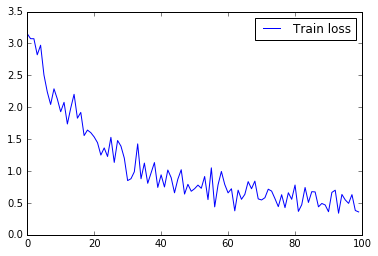

In [6]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 20 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 10
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # Build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 training loss: 3.6591 validation accuracy: 0.212800
Iter-2 training loss: 3.4536 validation accuracy: 0.212000
Iter-3 training loss: 3.3362 validation accuracy: 0.216800
Iter-4 training loss: 3.0952 validation accuracy: 0.235800
Iter-5 training loss: 2.6624 validation accuracy: 0.258000
Iter-6 training loss: 2.5122 validation accuracy: 0.282600
Iter-7 training loss: 2.3568 validation accuracy: 0.310400
Iter-8 training loss: 2.7865 validation accuracy: 0.337800
Iter-9 training loss: 2.5825 validation accuracy: 0.362400
Iter-10 training loss: 2.5632 validation accuracy: 0.381600
Iter-11 training loss: 2.6150 validation accuracy: 0.404600
Iter-12 training loss: 2.0278 validation accuracy: 0.422600
Iter-13 training loss: 1.8822 validation accuracy: 0.442800
Iter-14 training loss: 2.1943 validation accuracy: 0.456200
Iter-15 training loss: 1.8856 validation accuracy: 0.474400
Iter-16 training loss: 2.2767 validation accuracy: 0.488600
Iter-17 training loss: 1.4155 validation accuracy

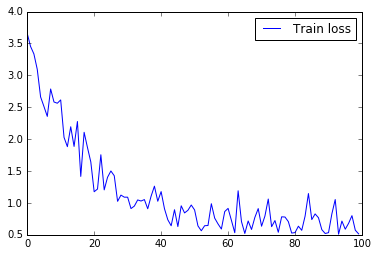

In [3]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 10 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 10
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # Build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 training loss: 4.3699 validation accuracy: 0.106600
Iter-2 training loss: 4.2065 validation accuracy: 0.109200
Iter-3 training loss: 3.8175 validation accuracy: 0.110400
Iter-4 training loss: 4.0557 validation accuracy: 0.112200
Iter-5 training loss: 4.1433 validation accuracy: 0.117200
Iter-6 training loss: 3.9006 validation accuracy: 0.121800
Iter-7 training loss: 3.4299 validation accuracy: 0.126000
Iter-8 training loss: 3.5944 validation accuracy: 0.134000
Iter-9 training loss: 3.5746 validation accuracy: 0.142800
Iter-10 training loss: 3.4936 validation accuracy: 0.154200
Iter-11 training loss: 2.9224 validation accuracy: 0.165400
Iter-12 training loss: 2.9877 validation accuracy: 0.176000
Iter-13 training loss: 3.6587 validation accuracy: 0.186400
Iter-14 training loss: 3.1328 validation accuracy: 0.199800
Iter-15 training loss: 3.4228 validation accuracy: 0.213600
Iter-16 training loss: 2.9927 validation accuracy: 0.223000
Iter-17 training loss: 3.1138 validation accuracy

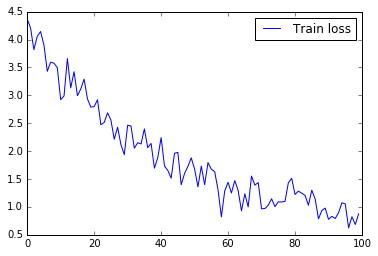

In [3]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 50 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 4
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # Build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 training loss: 5.6499 validation accuracy: 0.126000
Iter-2 training loss: 5.5059 validation accuracy: 0.129000
Iter-3 training loss: 5.2581 validation accuracy: 0.134200
Iter-4 training loss: 5.1726 validation accuracy: 0.139200
Iter-5 training loss: 5.0539 validation accuracy: 0.146000
Iter-6 training loss: 4.4976 validation accuracy: 0.155000
Iter-7 training loss: 4.6524 validation accuracy: 0.167800
Iter-8 training loss: 4.0470 validation accuracy: 0.177400
Iter-9 training loss: 4.0976 validation accuracy: 0.185000
Iter-10 training loss: 3.6090 validation accuracy: 0.190400
Iter-11 training loss: 4.1361 validation accuracy: 0.195800
Iter-12 training loss: 3.9103 validation accuracy: 0.200000
Iter-13 training loss: 3.9527 validation accuracy: 0.204200
Iter-14 training loss: 3.6845 validation accuracy: 0.207800
Iter-15 training loss: 3.7768 validation accuracy: 0.211000
Iter-16 training loss: 3.2070 validation accuracy: 0.215200
Iter-17 training loss: 3.4264 validation accuracy

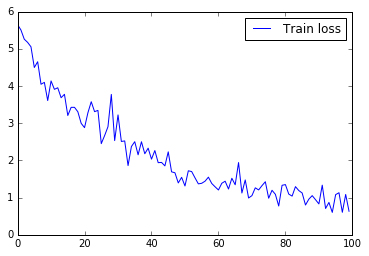

In [3]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 40 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 4
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 training loss: 7.8835 validation accuracy: 0.082200
Iter-2 training loss: 6.8587 validation accuracy: 0.085000
Iter-3 training loss: 5.8568 validation accuracy: 0.090600
Iter-4 training loss: 6.3994 validation accuracy: 0.095600
Iter-5 training loss: 5.1304 validation accuracy: 0.104000
Iter-6 training loss: 6.0559 validation accuracy: 0.111000
Iter-7 training loss: 5.9142 validation accuracy: 0.118000
Iter-8 training loss: 5.2320 validation accuracy: 0.127400
Iter-9 training loss: 4.1472 validation accuracy: 0.135200
Iter-10 training loss: 4.6250 validation accuracy: 0.144200
Iter-11 training loss: 4.0970 validation accuracy: 0.152000
Iter-12 training loss: 5.0647 validation accuracy: 0.159000
Iter-13 training loss: 4.7121 validation accuracy: 0.166200
Iter-14 training loss: 4.0924 validation accuracy: 0.173800
Iter-15 training loss: 4.7021 validation accuracy: 0.183400
Iter-16 training loss: 3.9339 validation accuracy: 0.192000
Iter-17 training loss: 3.0919 validation accuracy

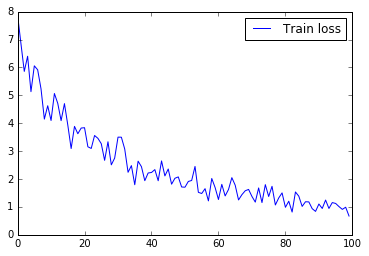

In [3]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 30 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 4
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 training loss: 4.9490 validation accuracy: 0.099400
Iter-2 training loss: 4.7768 validation accuracy: 0.102800
Iter-3 training loss: 4.1257 validation accuracy: 0.107000
Iter-4 training loss: 4.3070 validation accuracy: 0.108600
Iter-5 training loss: 4.4215 validation accuracy: 0.111800
Iter-6 training loss: 4.4410 validation accuracy: 0.114000
Iter-7 training loss: 4.0530 validation accuracy: 0.118800
Iter-8 training loss: 3.6373 validation accuracy: 0.122400
Iter-9 training loss: 3.6851 validation accuracy: 0.126400
Iter-10 training loss: 3.7518 validation accuracy: 0.133000
Iter-11 training loss: 3.8301 validation accuracy: 0.137800
Iter-12 training loss: 3.9978 validation accuracy: 0.143000
Iter-13 training loss: 3.7776 validation accuracy: 0.150800
Iter-14 training loss: 3.6619 validation accuracy: 0.156800
Iter-15 training loss: 3.6769 validation accuracy: 0.166200
Iter-16 training loss: 3.6105 validation accuracy: 0.174200
Iter-17 training loss: 3.3981 validation accuracy

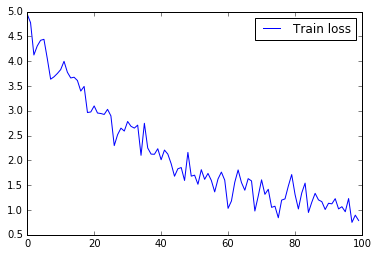

In [3]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 20 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 4
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 training loss: 4.3135 validation accuracy: 0.037000
Iter-2 training loss: 4.8087 validation accuracy: 0.046000
Iter-3 training loss: 3.8557 validation accuracy: 0.054800
Iter-4 training loss: 3.6322 validation accuracy: 0.060000
Iter-5 training loss: 3.9788 validation accuracy: 0.069600
Iter-6 training loss: 3.6795 validation accuracy: 0.077600
Iter-7 training loss: 3.8124 validation accuracy: 0.088800
Iter-8 training loss: 3.6667 validation accuracy: 0.099800
Iter-9 training loss: 4.0479 validation accuracy: 0.111800
Iter-10 training loss: 3.7656 validation accuracy: 0.125600
Iter-11 training loss: 3.0473 validation accuracy: 0.140800
Iter-12 training loss: 3.5275 validation accuracy: 0.152600
Iter-13 training loss: 3.1857 validation accuracy: 0.165200
Iter-14 training loss: 3.6096 validation accuracy: 0.176600
Iter-15 training loss: 3.2929 validation accuracy: 0.185800
Iter-16 training loss: 2.7087 validation accuracy: 0.198400
Iter-17 training loss: 3.0986 validation accuracy

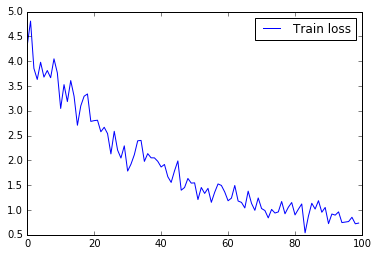

In [3]:
# # Hyper-parameters
# n_iter = 100 # number of epochs
# alpha = 1e-4 # learning_rate
# mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
# num_layers = 10 # depth 
# print_after = 1 # n_iter//10 # print loss for train, valid, and test
# num_hidden_units = 4
# p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# # build the model/NN and learn it: running session.
# nn = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

# nn.adam(X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
#            n_iter=n_iter, print_after=print_after)

# # # Kernel dead problem
# # y_pred = nn.test(X_test)
# # accs = np.mean(y_pred == y_test)
# # print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# # plt.plot(nn.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()